In [30]:
# Current future warning with pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import numpy as np
import pandas as pd
import pickle
from backtesting import Backtest, Strategy
from backtesting.lib import resample_apply
import matplotlib.pyplot as plt


# Loading Data

In [31]:
data = pd.read_csv("BTCUSDT-1m.csv", usecols = [0,1,2,3,4])
data["date"] = pd.to_datetime(data["date"], unit="ms")
data.columns = ["Date","Open","High","Low","Close"]
data.set_index("Date", inplace=True)

# Strategy Class

In [32]:
class MomentumStrategy(Strategy):

    small_threshold = 0
    large_threshold = 3

    def momentum(self, data):
        return data.pct_change(periods=7).to_numpy() * 100

    def init(self):
        self.pct_change_long = resample_apply("2h" , self.momentum, self.data.Close.s)
        self.pct_change_short = resample_apply("30T" , self.momentum, self.data.Close.s)

    def next(self):

        change_long = self.pct_change_long[-1]
        change_short = self.pct_change_short[-1]

        if self.position:

            if self.position.is_long and change_short < self.small_threshold:
                    self.position.close()
            elif self.position.is_short and change_short > -1*self.small_threshold:
                    self.position.close()
        else:
            if change_long > self.large_threshold and change_short > self.large_threshold:
                self.buy()
            elif change_long < -1*self.large_threshold and change_short < -1*self.small_threshold:
                self.sell()

# Test Run

In [33]:

# Useful for just running strategy once
bt = Backtest(data[ data.index < "2022-02-01" ], MomentumStrategy, cash=10_000_000, commission = 0.002)

stats = bt.optimize(
        small_threshold = list(np.arange(0,1,0.1)),
        large_threshold = list(np.arange(1,3,0.2)),
        maximize='Equity Final [$]')

small_threshold = stats._strategy.small_threshold
large_threshold = stats._strategy.large_threshold

print(stats)
print(stats._strategy)

print(small_threshold, large_threshold)
print(stats._equity_curve)

stats = bt.run()
bt.plot()

Start                     2022-01-01 00:00:00
End                       2022-01-31 23:59:00
Duration                     30 days 23:59:00
Exposure Time [%]                    8.241487
Equity Final [$]               10316722.75838
Equity Peak [$]                10995000.51376
Return [%]                           3.167228
Buy & Hold Return [%]              -16.828324
Return (Ann.) [%]                   44.358813
Volatility (Ann.) [%]               33.092178
Sharpe Ratio                         1.340462
Sortino Ratio                        5.148799
Calmar Ratio                          6.80409
Max. Drawdown [%]                   -6.519434
Avg. Drawdown [%]                   -1.264601
Max. Drawdown Duration       15 days 14:02:00
Avg. Drawdown Duration        1 days 03:18:00
# Trades                                   19
Win Rate [%]                        36.842105
Best Trade [%]                       4.381803
Worst Trade [%]                     -1.651913
Avg. Trade [%]                    

/home/chad/Desktop/walk-forward-optimization-backtestingpy/venv/lib/python3.8/site-packages/backtesting/_plotting.py:122: UserWarning: Data contains too many candlesticks to plot; downsampling to '5T'. See `Backtest.plot(resample=...)`
  warnings.warn(f"Data contains too many candlesticks to plot; downsampling to {freq!r}. "


Row(id='3151', ...)

# Walk forward

In [34]:
def walk_forward(
        strategy,
        data_full,
        warmup_bars,
        lookback_bars=28*1440,
        validation_bars=7*1440,
        cash=10_000_000, 
        commission=0.002):

    stats_master = []

    for i in range(lookback_bars, len(data_full)-validation_bars, validation_bars):

        print(i)

        # To do anchored walk-forward, just set the first slice here to 0
        sample_data = data_full.iloc[i-lookback_bars: i]

        bt_training = Backtest(sample_data, strategy, cash=cash, commission=commission)
        stats_training = bt_training.optimize(
                small_threshold = list(np.arange(0,1,0.1)),
                large_threshold = list(np.arange(1,3,0.2)),
                maximize='Equity Final [$]')

        small_threshold = stats_training._strategy.small_threshold
        large_threshold = stats_training._strategy.large_threshold

        
        validation_data = data_full.iloc[i-warmup_bars:i+validation_bars]
        bt_validation = Backtest(validation_data, strategy, cash=cash, commission=commission)
        stats_validation = bt_validation.run(
                small_threshold = small_threshold,
                large_threshold = large_threshold)

        stats_master.append(stats_validation)

    return stats_master

## Run walk-forward

In [35]:
lookback_bars = 28*1440
validation_bars = 7*1440
warmup_bars = 14*60

if os.path.exists("stats.pickle"):
    with open("stats.pickle", "rb") as f:
        stats = pickle.load(f)
else:
    stats = walk_forward(MomentumStrategy, data, warmup_bars = warmup_bars)
    with open("stats.pickle", "wb") as f:
        pickle.dump(stats, f)

## Plot stats of a particular test

In [36]:
def plot_stats(data, stats):
    equity_curve = stats._equity_curve
    aligned_data = data.reindex(equity_curve.index)
    bt = Backtest(aligned_data, MomentumStrategy, cash=10_000_000, commission=0.002)
    print(stats)
    bt.plot(results=stats)

In [37]:
plot_stats(data, stats[1])

Start                     2022-02-04 10:00:00
End                       2022-02-11 23:59:00
Duration                      7 days 13:59:00
Exposure Time [%]                     4.70696
Equity Final [$]                 9722185.9582
Equity Peak [$]                10118620.13936
Return [%]                           -2.77814
Buy & Hold Return [%]               11.515685
Return (Ann.) [%]                  -72.347843
Volatility (Ann.) [%]                3.704813
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -4.367389
Avg. Drawdown [%]                   -0.832318
Max. Drawdown Duration        4 days 04:16:00
Avg. Drawdown Duration        0 days 10:24:00
# Trades                                    4
Win Rate [%]                              0.0
Best Trade [%]                      -0.127045
Worst Trade [%]                     -1.938427
Avg. Trade [%]                    

/home/chad/Desktop/walk-forward-optimization-backtestingpy/venv/lib/python3.8/site-packages/backtesting/_plotting.py:122: UserWarning: Data contains too many candlesticks to plot; downsampling to '1T'. See `Backtest.plot(resample=...)`
  warnings.warn(f"Data contains too many candlesticks to plot; downsampling to {freq!r}. "


## Plot full equity curve of all validation tests

In [38]:
def plot_full_equity_curve(data, stats_list, warmup_bars, lookback_bars, overlay_price = True):
    equity_curves = [x["_equity_curve"].iloc[warmup_bars:] for x in stats_list]

    combined = pd.Series()
    for curve in equity_curves:

        # Need to normalise each equity curve to connect them up
        if len(combined) == 0:
            combined = curve["Equity"]/1e7
        else:
            combined = pd.concat([combined, (curve["Equity"]/1e7)*combined.iloc[-1]])

    last_date = combined.index[-1]
    aligned_price_data = data[data.index <= last_date].iloc[lookback_bars:]

    plt.style.use('fivethirtyeight')
    fig, ax1 = plt.subplots()
    # get rid of grid on graph
    ax1.grid(False)
    equity_line, = ax1.plot(combined.index, combined, color = "orange", label = "Equity")

    if overlay_price:
        ax2 = ax1.twinx()
        ax2.grid(False)
        price_line, = ax2.plot(aligned_price_data.index, aligned_price_data.Close, label = "BTCUSDT")
        ax1.legend(handles=[equity_line, price_line])
    else:
        ax1.legend(handles=[equity_line])

    plt.show()

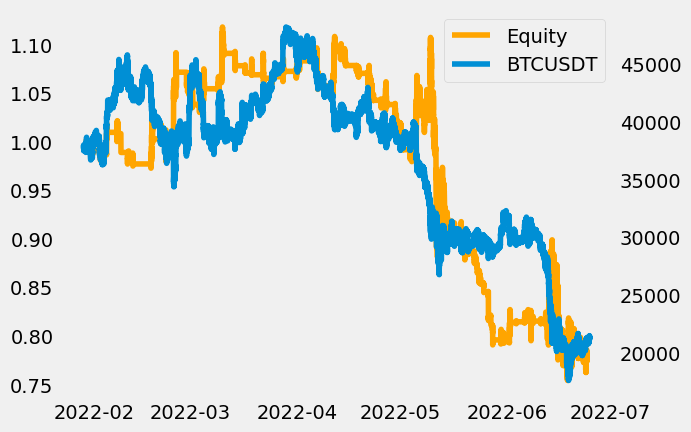

In [42]:
plot_full_equity_curve(data, stats, warmup_bars = warmup_bars,
                       lookback_bars = lookback_bars, overlay_price = True)

## Plot Flow graph of training vs test data

In [40]:
def plot_split_graph(
        data,
        lookback_bars=28*1440,
        validation_bars=7*1440,
        anchor = False):

    """
    Plot the flow diagram of the training vs test data
    """

    fig, ax = plt.subplots()
    fig.set_figwidth(12)

    ranges = list(range(lookback_bars, len(data)-validation_bars, validation_bars))

    for i in range(len(ranges)):

        # To do anchored walk-forward, just set the first slice here to 0

        if anchor == True:
            sample_data = data.iloc[0: ranges[i]]
        else:
            sample_data = data.iloc[ranges[i]-lookback_bars: ranges[i]]

        validation_data = data.iloc[ranges[i]:ranges[i]+validation_bars]

        plt.fill_between(sample_data.index, 
                [len(ranges) - i - 0.5]*len(sample_data.index),
                [len(ranges) - i + 0.5]*len(sample_data.index),
                color = "blue")
        plt.fill_between(validation_data.index, 
                [len(ranges) - i - 0.5]*len(validation_data.index),
                [len(ranges) - i + 0.5]*len(validation_data.index),
                color = "orange")

    plt.show()

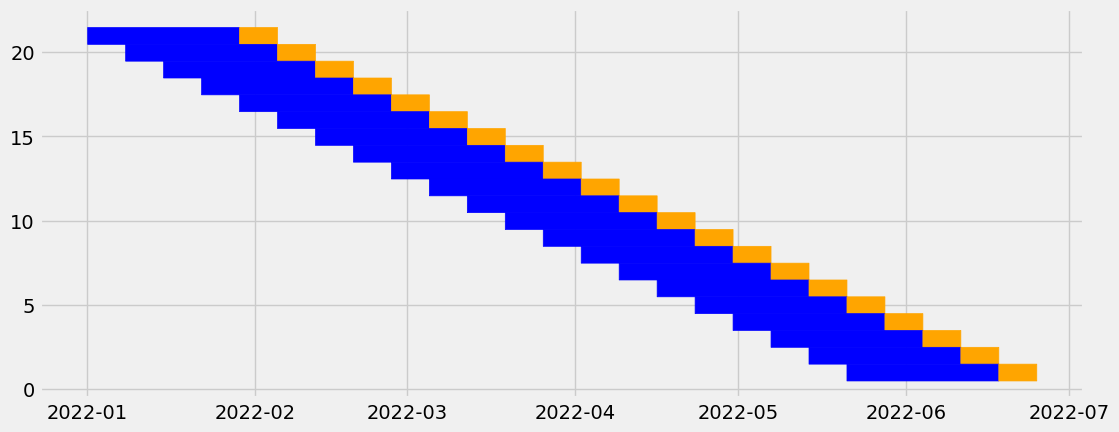

In [44]:
plot_split_graph(data, lookback_bars=lookback_bars, 
        validation_bars=validation_bars, anchor = False) 